# Lab 4 - Aspect-Based Sentiment Analysis



---















In this session, we demonstrate how to deal with the aspect-based sentiment analysis (ABSA). You can find the whole task description from (https://aclanthology.org/D19-1654.pdf).
This task provides a review text dataset with aspect.
Given a review and an aspect, we need to classify the sentiment conveyed towards that aspect on a  three-point scale:   POSITIVE, NEUTRAL, and NEGATIVE.
This is a multi-class classification task, and it needs to analyze the text and its aspect. 

Same as before, we are going to use Keras Sequential API in this session. The Sequential API allows you to make models layer-by-layer. You could modify the previous models to fit in the new task.

In [1]:
import keras
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras import backend as K
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.layers import LSTM, RNN, Dropout, Input, LeakyReLU, Bidirectional,Conv1D, GlobalMaxPooling1D
from keras.layers.core import Dense
from keras.models import Model

### Downloading and preprocessing data

Unlike the IMDB dataset that is included and preprocessed by the Keras, the dataset we will be using is the aspect-term sentiment analysis (ATSA) dataset, which consists of 5297 labeled reviews. These are split into 4,297 reviews for training and 500 reviews for testing and validation, respectively. 

For ATSA, the annotators extract aspect terms in the sentences and label the sentiment polarities with respect to the  aspect  terms.   The  sentences  that  consist  of only one aspect term or multiple aspects with the same  sentiment  polarities  are  deleted.  ATSA also provides the start and end positions in a sentence for each aspect term.

In [2]:
import requests
def downloadfile(url):
  rq = requests.get(url)
  open(url.split('/')[-1], 'wb').write(rq.content)
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/train.xml')
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/val.xml')
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/test.xml')


In [3]:
# The code is modified from https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data_process/utils.py
from xml.etree.ElementTree import parse

def parse_sentence_term(path, lowercase=False):
    tree = parse(path)
    sentences = tree.getroot()
    data = []
    split_char = '__split__'
    for sentence in sentences:
        text = sentence.find('text')
        if text is None:
            continue
        text = text.text
        if lowercase:
            text = text.lower()
        aspectTerms = sentence.find('aspectTerms')
        if aspectTerms is None:
            continue
        for aspectTerm in aspectTerms:
            term = aspectTerm.get('term')
            if lowercase:
                term = term.lower()
            polarity = aspectTerm.get('polarity')
            start = aspectTerm.get('from')
            end = aspectTerm.get('to')
            piece = [text , term,  polarity , start , end]
            data.append(piece)
    return data
train = parse_sentence_term("train.xml",True)
val = parse_sentence_term("val.xml",True)
test = parse_sentence_term("test.xml",True)

print("Training entries: {}".format(len(train)))
print("Test entries: {}".format(len(test)))

Training entries: 11186
Test entries: 1336


We now can start playing around with the data, let’s first see some examples:

In [4]:
print("SENTENCE \t ASPECT \t LABEL \t ASPECT-START-INDEX \t ASPECT-END-INDEX")
print(train[0])
print(train[1])
print(train[2])
print(train[3])
print(train[4])

SENTENCE 	 ASPECT 	 LABEL 	 ASPECT-START-INDEX 	 ASPECT-END-INDEX
['the decor is not special at all but their food and amazing prices make up for it.', 'decor', 'negative', '4', '9']
['the decor is not special at all but their food and amazing prices make up for it.', 'food', 'positive', '42', '46']
['the decor is not special at all but their food and amazing prices make up for it.', 'prices', 'positive', '59', '65']
['when tables opened up, the manager sat another party before us.', 'tables', 'neutral', '5', '11']
['when tables opened up, the manager sat another party before us.', 'manager', 'negative', '27', '34']


We could use this dataset to try an "unknown aspect" task, if we assume that the ASPECT, LABEL and START/END-INDEX fields are what the model must predict. But here we will attempt a simpler "known aspect" task: we will assume that we know ASPECT and START/END-INDEX and the model must just predict the LABEL for a given combination of aspect and sentence.

First, build a vocabulary based on the training dataset. 

In [5]:
voc = []
from keras.preprocessing.text import text_to_word_sequence
for example in train:
  text_tokens = text_to_word_sequence(example[0])
  aspect_tokens = text_to_word_sequence(example[1])
  voc.extend(aspect_tokens)
  voc.extend(text_tokens)
voc = sorted(set(voc))
print(len(voc))

word_index = dict()
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  
word_index["<EOS>"] = 3
for w in voc:
  word_index[w] = len(word_index)
print(len(word_index))

7894
7898


According to the word_index and the tokenizer function (text_to_word_sequence), we can convert the review text and aspect words to word tokens and integers separately:


In [6]:
word_index['decor']

1926

In [7]:
# Please write your code to generate the following data
x_train_review = [text_to_word_sequence(w[0]) for w in train]
x_train_aspect = [text_to_word_sequence(w[1]) for w in train]

#x_train_review_int = [word_index.get(w[0],2) for w in train]
x_train_review_int = [[word_index.get(word,2) for word in line] for line in x_train_review]

x_train_aspect_int = [word_index.get(w[1],2) for w in train] #update by 
x_dev_review = [text_to_word_sequence(w[0]) for w in val]
x_dev_aspect = [text_to_word_sequence(w[1]) for w in val]
x_dev_review_int = [[word_index.get(word,2) for word in line] for line in x_dev_review]
x_dev_aspect_int = [word_index.get(w[1],2) for w in val]

x_test_review = [text_to_word_sequence(w[0]) for w in test]
x_test_aspect = [text_to_word_sequence(w[1]) for w in test]
x_test_review_int = [[word_index.get(word,2) for word in line] for line in x_test_review]
x_test_aspect_int = [word_index.get(w[0],2) for w in test]


# your code goes here:



# If use the previous word_index, you can get a print result like:
assert len(x_train_aspect) == len(train)
assert len(x_train_aspect) == len(x_train_aspect_int)
assert len(x_test_aspect) == len(test)
assert len(x_test_aspect) == len(x_test_aspect_int)
print("x_train_review[0]:")
print(x_train_review[0])
print("x_train_aspect[0]:")
print(x_train_aspect[0])
print("x_train_review_int[0]:")
print(x_train_review_int[0])
print("x_train_aspect_int[0]:")
print(x_train_aspect_int[0])

x_train_review[0]:
['the', 'decor', 'is', 'not', 'special', 'at', 'all', 'but', 'their', 'food', 'and', 'amazing', 'prices', 'make', 'up', 'for', 'it']
x_train_aspect[0]:
['decor']
x_train_review_int[0]:
[7049, 1926, 3655, 4655, 6516, 564, 330, 1079, 7053, 2802, 393, 369, 5364, 4150, 7437, 2812, 3665]
x_train_aspect_int[0]:
1926


We use 4 to represent "positive", 2 for "neutral", and 1 for "negative". Then we can convert the lables to numbers.

In [8]:
def label2int(dataset):
  y = []
  for example in dataset:
    if example[2].lower() == "negative":
      y.append([0,0,1])
    elif example[2].lower() == "neutral":
      y.append([0,1,0])
    else:
      # assert example[2].lower() == "positive"
      y.append([1,0,0])
  return y
  
y_train = label2int(train)
y_dev = label2int(val)
y_test = label2int(test)
y_train = np.array(y_train)
y_dev = np.array(y_dev)
y_test = np.array(y_test)

print(y_train[0])
print(y_train[1])
print(y_train[2])
print(y_train[3])
print(y_train[4])

[0 0 1]
[1 0 0]
[1 0 0]
[0 1 0]
[0 0 1]


Now we have almost done the data preprocessing. Unlike the previous lab, there are two x (review and aspect) to input the model in here. The easiest way is to combine the review and aspect into one sentence and then input it into the model. Thus we can use the previous model directly.

(This means our model is similar to a simplified version of the Vo & Zhang model from the lectures: we have an input sequence containing an aspect embedding paired with the sentence word embeddings (but not separating into left & right sentence context as Vo & Zhang do).

In [9]:
# Please write your code to combine the x_*_review and x_*_aspect into the following varibles
x_train = []
x_train_int = []
x_dev = []
x_dev_int = []
x_test = []
x_test_int = []
from keras.preprocessing.sequence import pad_sequences
max_len = 128

for i in range(len(x_train_review)):
  temp = (x_train_aspect[i] + ['<START>'] + x_train_review[i])
  x_train.append(temp)
  x_train_int.append([word_index.get(w,2) for w in temp])


x_train_pad = pad_sequences(x_train_int, maxlen=max_len, padding='post')

for i in range(len(x_dev_review)):
  temp = (x_dev_aspect[i] + ['<START>'] + x_dev_review[i])
  x_dev.append(temp)
  x_dev_int.append([word_index.get(w,2) for w in temp])
  
x_dev_pad = pad_sequences(x_dev_int, maxlen=max_len, padding='post')


for i in range(len(x_test_review)):
  temp = (x_test_aspect[i] + ['<START>'] + x_test_review[i])
  x_test.append(temp)
  x_test_int.append([word_index.get(w,2) for w in temp])
  
x_test_pad = pad_sequences(x_test_int, maxlen=max_len, padding='post')



# Tips: 
# 1) We can use the special token <START> to concatenate the reviews and aspects.
# 2) After combine them, do not foget to pad the sequences.


# Don't forget the to use np.array function to wrap the ouput of pad_sequences function, such as: x_train_pad = np.array(x_train_pad)
# Only pad the *_int varibles
print("Before paded:")
print(x_train[0])
print(x_train_int[0])
print("After paded:")
print(x_train_pad[0])

Before paded:
['decor', '<START>', 'the', 'decor', 'is', 'not', 'special', 'at', 'all', 'but', 'their', 'food', 'and', 'amazing', 'prices', 'make', 'up', 'for', 'it']
[1926, 1, 7049, 1926, 3655, 4655, 6516, 564, 330, 1079, 7053, 2802, 393, 369, 5364, 4150, 7437, 2812, 3665]
After paded:
[1926    1 7049 1926 3655 4655 6516  564  330 1079 7053 2802  393  369
 5364 4150 7437 2812 3665    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


#Model 1: Previous models without pre-trained word embeddings

## Model 1-1: Neural bag of words without pre-trained word embeddings

Now we use the model2 in lab4 to deal with our task. However, the previous model works only for the binary classification task. Therefore, we need to modify the output layer to fix the multi-class problem. You can read this tutorial for more details: https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

In [10]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)


In [ ]:
# your code goes here   
# Tips: The activation function of the output layer is softmax.

# your code goes here
from keras.models import Model
import tensorflow as tf
VOCAB_SIZE = len(word_index)
# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
input = Input((128,), dtype='int32')
embedding = Embedding(VOCAB_SIZE, 100, name='target_embed_layer',
                        	embeddings_initializer='glorot_uniform',
                         	input_length=500, mask_zero=True)(input)
                          
                          
avg_pool = GlobalAveragePooling1D()(embedding) 

dense_layer = tf.keras.layers.Dense(units=16, name="dense_layer")(avg_pool)
output_layer = tf.keras.layers.Dense(units=3, name="dense_layer_output", activation = 'sigmoid')(dense_layer)

model = Model(inputs=[input], outputs=[output_layer])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 target_embed_layer (Embeddi  (None, 128, 100)         789800    
 ng)                                                             
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_layer (Dense)         (None, 16)                1616      
                                                                 
 dense_layer_output (Dense)  (None, 3)                 51        
                                                                 
Total params: 791,467
Trainable params: 791,467
Non-trainable

In [ ]:
history = model.fit(x_train_pad,
                    y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_dev_pad, y_dev),
                    verbose=1)

Epoch 1/40
22/22 [==============================] - 1s 13ms/step - loss: 0.6762 - accuracy: 0.4539 - val_loss: 0.6545 - val_accuracy: 0.4932
Epoch 2/40
22/22 [==============================] - 0s 8ms/step - loss: 0.6338 - accuracy: 0.4744 - val_loss: 0.6152 - val_accuracy: 0.4542
Epoch 3/40
22/22 [==============================] - 0s 8ms/step - loss: 0.6051 - accuracy: 0.4509 - val_loss: 0.5998 - val_accuracy: 0.4542
Epoch 4/40
22/22 [==============================] - 0s 8ms/step - loss: 0.5901 - accuracy: 0.4584 - val_loss: 0.5862 - val_accuracy: 0.4647
Epoch 5/40
22/22 [==============================] - 0s 7ms/step - loss: 0.5734 - accuracy: 0.4937 - val_loss: 0.5737 - val_accuracy: 0.4887
Epoch 6/40
22/22 [==============================] - 0s 7ms/step - loss: 0.5572 - accuracy: 0.5253 - val_loss: 0.5629 - val_accuracy: 0.5180
Epoch 7/40
22/22 [==============================] - 0s 7ms/step - loss: 0.5418 - accuracy: 0.5461 - val_loss: 0.5540 - val_accuracy: 0.5308
Epoch 8/40
22/22 [=

In [ ]:
results = model.evaluate(x_test_pad, y_test)

42/42 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.5614


The accuracy of lab3 model2 in this task is around 46%. If you use the "glorot_uniform" initialization method, the accuracy can reach around 55%.

##  Model 1-2: CNN or LSTM without pre-trained word embeddings

Please try one more model (CNN or LSTM) without pre-trained word embeddings in here:

In [ ]:
# Try CNN or LSTM without pre-trained word embeddings in here:

# your code goes here   
# Tips: The activation function of the output layer is softmax.

# your code goes here
from keras.models import Model
import tensorflow as tf
VOCAB_SIZE = len(word_index)
# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
input = Input((128,), dtype='int32')
embedding = Embedding(VOCAB_SIZE, 100, name='target_embed_layer',
                        	embeddings_initializer='glorot_uniform',
                         	input_length=500, mask_zero=True)(input)
                          
lstm = tf.keras.layers.LSTM(4)(embedding)

dense_layer = tf.keras.layers.Dense(units=16, name="dense_layer")(lstm)
output_layer = tf.keras.layers.Dense(units=3, name="dense_layer_output", activation = 'sigmoid')(dense_layer)

model1_2 = Model(inputs=[input], outputs=[output_layer])
model1_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1_2.summary()



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128)]             0         
                                                                 
 target_embed_layer (Embeddi  (None, 128, 100)         789800    
 ng)                                                             
                                                                 
 lstm (LSTM)                 (None, 4)                 1680      
                                                                 
 dense_layer (Dense)         (None, 16)                80        
                                                                 
 dense_layer_output (Dense)  (None, 3)                 51        
                                                                 
Total params: 791,611
Trainable params: 791,611
Non-trainable params: 0
_____________________________________________________

In [ ]:
history = model1_2.fit(x_train_pad,
                    y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_dev_pad, y_dev),
                    verbose=1)

Epoch 1/40
22/22 [==============================] - 9s 89ms/step - loss: 0.6797 - accuracy: 0.3687 - val_loss: 0.6617 - val_accuracy: 0.4264
Epoch 2/40
22/22 [==============================] - 0s 16ms/step - loss: 0.6414 - accuracy: 0.4548 - val_loss: 0.6249 - val_accuracy: 0.4542
Epoch 3/40
22/22 [==============================] - 0s 14ms/step - loss: 0.6136 - accuracy: 0.4529 - val_loss: 0.6112 - val_accuracy: 0.4535
Epoch 4/40
22/22 [==============================] - 0s 14ms/step - loss: 0.6006 - accuracy: 0.4525 - val_loss: 0.6039 - val_accuracy: 0.4580
Epoch 5/40
22/22 [==============================] - 0s 14ms/step - loss: 0.5870 - accuracy: 0.4616 - val_loss: 0.5974 - val_accuracy: 0.4625
Epoch 6/40
22/22 [==============================] - 0s 13ms/step - loss: 0.5730 - accuracy: 0.4642 - val_loss: 0.5929 - val_accuracy: 0.4640
Epoch 7/40
22/22 [==============================] - 0s 13ms/step - loss: 0.5591 - accuracy: 0.4767 - val_loss: 0.5899 - val_accuracy: 0.4572
Epoch 8/40
22

In [ ]:
results = model1_2.evaluate(x_test_pad, y_test)

42/42 [==============================] - 0s 4ms/step - loss: 0.7560 - accuracy: 0.5546


CNN

In [ ]:
from keras.layers.pooling import GlobalMaxPooling1D
hidden_layer=16

from keras.models import Model

input = Input((128,), dtype='int32')
embedding = Embedding(VOCAB_SIZE, 100, name='embed_layer',
                        	embeddings_initializer='glorot_uniform',
                         	input_length=500, mask_zero=True)(input)
conv = tf.keras.layers.Conv1D(100,8)(embedding)
pool = GlobalMaxPooling1D()(conv)
hidden = Dense(16)(pool)
output_layer = tf.keras.layers.Dense(units=3, name="dense_layer_output", activation = 'sigmoid')(hidden)

model1_cnn = Model(inputs=[input], outputs=[output_layer])
model1_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1_cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 embed_layer (Embedding)     (None, 128, 100)          789800    
                                                                 
 conv1d (Conv1D)             (None, 121, 100)          80100     
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 16)                1616      
                                                                 
 dense_layer_output (Dense)  (None, 3)                 51        
                                                           

In [ ]:
history = model1_cnn.fit(x_train_pad,
                    y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_dev_pad, y_dev),
                    verbose=1)

Epoch 1/40
22/22 [==============================] - 10s 398ms/step - loss: 0.6475 - accuracy: 0.4017 - val_loss: 0.6187 - val_accuracy: 0.4535
Epoch 2/40
22/22 [==============================] - 9s 388ms/step - loss: 0.6020 - accuracy: 0.4593 - val_loss: 0.5883 - val_accuracy: 0.4812
Epoch 3/40
22/22 [==============================] - 9s 386ms/step - loss: 0.5585 - accuracy: 0.5275 - val_loss: 0.5423 - val_accuracy: 0.5706
Epoch 4/40
22/22 [==============================] - 9s 391ms/step - loss: 0.4891 - accuracy: 0.6483 - val_loss: 0.4882 - val_accuracy: 0.6321
Epoch 5/40
22/22 [==============================] - 9s 391ms/step - loss: 0.4291 - accuracy: 0.7120 - val_loss: 0.4756 - val_accuracy: 0.6471
Epoch 6/40
22/22 [==============================] - 8s 385ms/step - loss: 0.3899 - accuracy: 0.7389 - val_loss: 0.4770 - val_accuracy: 0.6449
Epoch 7/40
22/22 [==============================] - 9s 416ms/step - loss: 0.3611 - accuracy: 0.7675 - val_loss: 0.4865 - val_accuracy: 0.6419
Epoch

In [ ]:
results = model1_cnn.evaluate(x_test_pad, y_test)

42/42 [==============================] - 0s 10ms/step - loss: 1.1167 - accuracy: 0.6078


# Model 2: Using pre-trained word embeddings

### Preparing pre-trained word embeddings (GLOVE)

The Embedding layer can be used to load a pre-trained word embedding model. We are going to use GloVe embeddings, which you can read about it here (https://nlp.stanford.edu/projects/glove/). GloVe stands for "Global Vectors for Word Representation". It's a somewhat popular embedding technique based on factorizing a matrix of word co-occurence statistics. You can download GloVe and we can seed the Keras Embedding layer with weights from the pre-trained embedding for the words in your dataset.
First, we need to read GloVe and map words to GloVe:


In [12]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

Now, we create our pre-trained Embedding layer:

In [13]:
from keras.initializers import Constant
import tensorflow as tf
lstm = tf.keras.layers.LSTM(4)
def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [14]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'

--2022-03-09 13:57:00--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-09 13:57:00--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-09 13:57:00--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

We freeze the weights. To create the model: 

In [15]:
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.50d.txt')
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.100d.txt')
wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.300d.txt')

# vocabLen = len(wordToIndex) + 1 

EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)

Size of Embedding:  300


### Convert the data to GLOVE word index

The index in our vocabulary is different from that in GLOVE. For example, the word "you" corresponds to 394475 in GLOVE, while it corresponds to another index in our vocabulary. Thus we can not directly use the index data in the last section. We convert them from text tokens to GLOVE word index.

In [16]:
print(wordToIndex["you"])
print(indexToWord[394475])
print(word_index["you"])

394475
you
7856


In [17]:
print(wordToIndex["unk"])

372306


In [18]:
from tensorflow.python.framework import device
# Please write your code to generate the following data
x_train_review_glove = [[wordToIndex.get(v,372306) for v in w] for w in x_train_review]
x_train_aspect_glove = [wordToIndex.get(w[1],372306) for w in train]


x_dev_review_glove = [[wordToIndex.get(v,372306) for v in w] for w in x_dev_review]
x_dev_aspect_glove = [wordToIndex.get(w[1],372306) for w in val]

x_test_review_glove = [[wordToIndex.get(v,372306) for v in w] for w in x_test_review]
x_test_aspect_glove = [wordToIndex.get(w[1],372306) for w in test]

# You should get a print result like:
assert len(x_train_review_glove) == len(train)
assert len(x_train_aspect_glove) == len(x_train_aspect_int)
assert len(x_test_review_glove) == len(test)
assert len(x_test_aspect_glove) == len(x_test_aspect_int)
print("x_train_review_glove[0]:")
print(x_train_review_glove[0])
print("x_train_aspect_glove[0]:")
print(x_test_aspect_glove[0])



x_train_review_glove[0]:
[357266, 118926, 192973, 264550, 338995, 62065, 51582, 87775, 357354, 151204, 54718, 53201, 292136, 231458, 373317, 151349, 193716]
x_train_aspect_glove[0]:
151204


In [19]:
indexToWord[151204]

'food'

As before, we concatenate the tweets and topics for fitting in the previous model. Let us do it again for GLOVE version variables.

In [ ]:
# Please write your code to combine the x_*_review_glove and x_*_aspect_glove into the following varibles
x_train_glove =[]
x_dev_glove = []
x_test_glove = []

def combine_x(a,b):
  c = []
  for i in range(len(b)):
    c.append([a[i]] + [1,] + b[i])
  return c
# Tips: 
# 1) There is no <START> token in GLOVE. Here we can use integer 1 to concatenate.
# 2) After combine them, do not foget to pad the sequences.

#######################TODO: REMOVE FOLLOWING CODE####################

x_train_glove = combine_x(x_train_aspect_glove,x_train_review_glove)
x_dev_glove   = combine_x(x_dev_aspect_glove  ,x_dev_review_glove)
x_test_glove  = combine_x(x_test_aspect_glove ,x_test_review_glove)


x_train_pad_glove = keras.preprocessing.sequence.pad_sequences(x_train_glove,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=128)

x_dev_pad_glove = keras.preprocessing.sequence.pad_sequences(x_dev_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=128)

x_test_pad_glove = keras.preprocessing.sequence.pad_sequences(x_test_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=128)
x_train_pad_glove = np.array(x_train_pad_glove)
x_dev_pad_glove = np.array(x_dev_pad_glove)
x_test_pad_glove = np.array(x_test_pad_glove)
#######################TODO: REMOVE ABOVE CODE####################

# Don't forget the to use np.array function to wrap the ouput of pad_sequences function, such as: x_train_pad = np.array(x_train_pad)
# Only pad the *_int varibles
print("Before paded:")
print(x_train_glove[0])
print("After paded:")
print(x_train_pad_glove[0])

Before paded:
[118926, 1, 357266, 118926, 192973, 264550, 338995, 62065, 51582, 87775, 357354, 151204, 54718, 53201, 292136, 231458, 373317, 151349, 193716]
After paded:
[118926      1 357266 118926 192973 264550 338995  62065  51582  87775
 357354 151204  54718  53201 292136 231458 373317 151349 193716      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0

## Model 2-1: Neural bag of words using pre-trained word embeddings

We use model3-1 in lab4 to deal with this task.

In [ ]:
# your code goes here
# Tips: Do not misuse the training data

# your code goes here
from keras.models import Model
import tensorflow as tf
VOCAB_SIZE = len(word_index)
# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
input = Input((128,), dtype='int32')
embedding = createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)(input)
                                                    
avg_pool = GlobalAveragePooling1D()(embedding) 

dense_layer = tf.keras.layers.Dense(units=16, name="dense_layer")(avg_pool)
output_layer = tf.keras.layers.Dense(units=3, name="dense_layer_output", activation = 'sigmoid')(dense_layer)

model2_1 = Model(inputs=[input], outputs=[output_layer])
model2_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
model2_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 128, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_layer (Dense)         (None, 16)                4816      
                                                                 
 dense_layer_output (Dense)  (None, 3)                 51        
                                                                 
Total params: 120,005,167
Trainable params: 4,867
Non-trainab

The accuracy is around 56%. In this version, the "glorot_uniform" initialization method does not improve model performance significantly.

In [ ]:
history = model2_1.fit(x_train_pad_glove,
                    y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_dev_pad_glove, y_dev),
                    verbose=1)

Epoch 1/40
22/22 [==============================] - 0s 15ms/step - loss: 0.5544 - accuracy: 0.5341 - val_loss: 0.5557 - val_accuracy: 0.5368
Epoch 2/40
22/22 [==============================] - 0s 14ms/step - loss: 0.5539 - accuracy: 0.5335 - val_loss: 0.5547 - val_accuracy: 0.5368
Epoch 3/40
22/22 [==============================] - 0s 14ms/step - loss: 0.5534 - accuracy: 0.5362 - val_loss: 0.5550 - val_accuracy: 0.5398
Epoch 4/40
22/22 [==============================] - 0s 14ms/step - loss: 0.5530 - accuracy: 0.5359 - val_loss: 0.5543 - val_accuracy: 0.5375
Epoch 5/40
22/22 [==============================] - 0s 14ms/step - loss: 0.5524 - accuracy: 0.5346 - val_loss: 0.5535 - val_accuracy: 0.5443
Epoch 6/40
22/22 [==============================] - 0s 14ms/step - loss: 0.5520 - accuracy: 0.5365 - val_loss: 0.5546 - val_accuracy: 0.5405
Epoch 7/40
22/22 [==============================] - 0s 14ms/step - loss: 0.5519 - accuracy: 0.5375 - val_loss: 0.5529 - val_accuracy: 0.5450
Epoch 8/40
22

In [ ]:
results2_1 = model2_1.evaluate(x_test_pad_glove, y_test)
print("Loss: {} and Accuracy: {}".format(results2_1[0], results2_1[1]))

42/42 [==============================] - 0s 2ms/step - loss: 0.5397 - accuracy: 0.5689
Loss: 0.5397483110427856 and Accuracy: 0.56886225938797


##  Model 2-2: CNN or LSTM with pre-trained word embeddings

Please try one more model (CNN or LSTM) with pre-trained word embeddings in here:

In [ ]:
# your code goes here

# Try CNN or LSTM without pre-trained word embeddings in here:

# your code goes here   
# Tips: The activation function of the output layer is softmax.

# your code goes here
from keras.models import Model
import tensorflow as tf
VOCAB_SIZE = len(word_index)
# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
input = Input((128,), dtype='int32')
embedding = createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)(input)
                          
lstm = tf.keras.layers.LSTM(4)(embedding)

dense_layer = tf.keras.layers.Dense(units=16, name="dense_layer")(lstm)
output_layer = tf.keras.layers.Dense(units=3, name="dense_layer_output", activation = 'sigmoid')(dense_layer)

model2_2 = Model(inputs=[input], outputs=[output_layer])
model2_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])




In [ ]:
model2_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 128, 300)         120000300 
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 4)                 4880      
                                                                 
 dense_layer (Dense)         (None, 16)                80        
                                                                 
 dense_layer_output (Dense)  (None, 3)                 51        
                                                                 
Total params: 120,005,311
Trainable params: 5,011
Non-trainable params: 120,000,300
_________________________________________

In [ ]:
history = model2_2.fit(x_train_pad_glove,
                    y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_dev_pad_glove, y_dev),
                    verbose=1)

Epoch 1/40
22/22 [==============================] - 4s 113ms/step - loss: 0.6851 - accuracy: 0.4479 - val_loss: 0.6757 - val_accuracy: 0.4535
Epoch 2/40
22/22 [==============================] - 2s 92ms/step - loss: 0.6662 - accuracy: 0.4507 - val_loss: 0.6546 - val_accuracy: 0.4535
Epoch 3/40
22/22 [==============================] - 2s 94ms/step - loss: 0.6441 - accuracy: 0.4507 - val_loss: 0.6317 - val_accuracy: 0.4535
Epoch 4/40
22/22 [==============================] - 2s 90ms/step - loss: 0.6250 - accuracy: 0.4507 - val_loss: 0.6197 - val_accuracy: 0.4535
Epoch 5/40
22/22 [==============================] - 2s 90ms/step - loss: 0.6204 - accuracy: 0.4507 - val_loss: 0.6192 - val_accuracy: 0.4535
Epoch 6/40
22/22 [==============================] - 2s 91ms/step - loss: 0.6201 - accuracy: 0.4507 - val_loss: 0.6192 - val_accuracy: 0.4535
Epoch 7/40
22/22 [==============================] - 2s 97ms/step - loss: 0.6201 - accuracy: 0.4507 - val_loss: 0.6192 - val_accuracy: 0.4535
Epoch 8/40
2

In [ ]:
results2_2 = model2_2.evaluate(x_test_pad_glove, y_test)
print("Loss: {} and Accuracy: {}".format(results2_1[0], results2_1[1]))

42/42 [==============================] - 0s 10ms/step - loss: 0.6192 - accuracy: 0.4543
Loss: 0.5397483110427856 and Accuracy: 0.56886225938797


In [ ]:
from keras.layers.pooling import GlobalMaxPooling1D
hidden_layer=16

from keras.models import Model

input = Input((128,), dtype='int32')
embedding = createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)(input)
conv = tf.keras.layers.Conv1D(100,8)(embedding)
pool = GlobalMaxPooling1D()(conv)
hidden = Dense(16)(pool)
output_layer = tf.keras.layers.Dense(units=3, name="dense_layer_output", activation = 'sigmoid')(hidden)

model2_cnn = Model(inputs=[input], outputs=[output_layer])
model2_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
model2_cnn.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 128, 300)         120000300 
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 121, 100)          240100    
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 16)                1616      
                                                                 
 dense_layer_output (Dense)  (None, 3)                 51  

In [ ]:
history = model2_2.fit(x_train_pad_glove,
                    y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_dev_pad, y_dev),
                    verbose=1)

Epoch 1/40
22/22 [==============================] - 2s 98ms/step - loss: 0.6201 - accuracy: 0.4507 - val_loss: 0.6192 - val_accuracy: 0.4535
Epoch 2/40
22/22 [==============================] - 2s 98ms/step - loss: 0.6201 - accuracy: 0.4507 - val_loss: 0.6192 - val_accuracy: 0.4535
Epoch 3/40
22/22 [==============================] - 2s 97ms/step - loss: 0.6201 - accuracy: 0.4507 - val_loss: 0.6192 - val_accuracy: 0.4535
Epoch 4/40
22/22 [==============================] - 2s 95ms/step - loss: 0.6201 - accuracy: 0.4507 - val_loss: 0.6192 - val_accuracy: 0.4535
Epoch 5/40
22/22 [==============================] - 2s 96ms/step - loss: 0.6201 - accuracy: 0.4507 - val_loss: 0.6192 - val_accuracy: 0.4535
Epoch 6/40
22/22 [==============================] - 2s 95ms/step - loss: 0.6201 - accuracy: 0.4507 - val_loss: 0.6192 - val_accuracy: 0.4535
Epoch 7/40
22/22 [==============================] - 2s 95ms/step - loss: 0.6201 - accuracy: 0.4507 - val_loss: 0.6192 - val_accuracy: 0.4535
Epoch 8/40
22

In [ ]:
results2_cnn = model2_cnn.evaluate(x_test_pad_glove, y_test)
print("Loss: {} and Accuracy: {}".format(results2_1[0], results2_1[1]))

42/42 [==============================] - 1s 18ms/step - loss: 0.8397 - accuracy: 0.3308
Loss: 0.5397483110427856 and Accuracy: 0.56886225938797


#  Model 3: Model with multiple-input

Model 1 and 2 are copied from lab4. We build new models in this section. 

In models 1 and 2, we combine the reviews and aspects to input into the models. In model 3, we separately input these two data into the model and use different layers to analyze them. 

(This will give us a model similar to a simplified version of the Xue & Li model from the lectures - we have a separate paths through the network for the aspect embedding and the sentence, being combined - but we don't have to use gating like Xue & Li).

In [20]:
# Padding review and aspect separately
x_train_review_pad_glove = keras.preprocessing.sequence.pad_sequences(x_train_review_glove,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=128)

x_dev_review_pad_glove = keras.preprocessing.sequence.pad_sequences(x_dev_review_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=128)

x_test_review_pad_glove = keras.preprocessing.sequence.pad_sequences(x_test_review_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=128)

In [21]:
la = []
for i in range(len(x_train_aspect_glove)):
  la.append([x_train_aspect_glove[i]])

In [22]:
lb = []
for i in range(len(x_dev_aspect_glove)):
  lb.append([x_dev_aspect_glove[i]])

In [23]:
lc = []
for i in range(len(x_test_aspect_glove)):
  lc.append([x_test_aspect_glove[i]])

In [24]:
x_train_aspect_pad_glove = keras.preprocessing.sequence.pad_sequences(la,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=16)

x_dev_aspect_pad_glove = keras.preprocessing.sequence.pad_sequences(lb,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=16)

x_test_aspect_pad_glove = keras.preprocessing.sequence.pad_sequences(lc,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=16)

Getting our data ready for the  model inputs, hence converting them to numpy arrays.

In [25]:
x_train_review_pad_glove = np.array(x_train_review_pad_glove)
x_dev_review_pad_glove = np.array(x_dev_review_pad_glove)
x_test_review_pad_glove = np.array(x_test_review_pad_glove)
x_train_aspect_pad_glove = np.array(x_train_aspect_pad_glove)
x_dev_aspect_pad_glove = np.array(x_dev_aspect_pad_glove)
x_test_aspect_pad_glove = np.array(x_test_aspect_pad_glove)

## Model 3-1 Neural bag of words model with multiple-input

Model 3-1 needs you to modify the model 2-1 to be compatible with multiple-input.
You could find some tutorial examples from (https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/).

Please print the model summary and visualize it using vis_utils.

In [26]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable)
    return embeddingLayer

In [ ]:
# your code goes here

from keras.layers import Input, Embedding, Dense, concatenate
from keras.models import Model
from keras.layers.core import Dense, Reshape

# define two sets of inputs
A = Input(shape=(128,), dtype='int32')
B = Input(shape=(16,), dtype='int32')


# the first branch operates on the first input
glove_embeddingA = createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)(A)
globalavgpoolinglayerA = GlobalAveragePooling1DMasked()(glove_embeddingA)
hidden1 = Dense(16)(globalavgpoolinglayerA)

x = Model(inputs=A, outputs=hidden1)

# the second branch opreates on the second input
glove_embeddingB = createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)(B)
globalavgpoolinglayerB = GlobalAveragePooling1DMasked()(glove_embeddingB)
hidden2 = Dense(16)(globalavgpoolinglayerB)

y = Model(inputs=B, outputs=hidden2)

# combine the output of the two branches
combined = concatenate([x.output, y.output])


z = Dense(3, activation='softmax')(combined)

model31 = Model(inputs=[x.input, y.input], outputs=z)
model31.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
model31.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 128, 300)     120000300   ['input_6[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 16, 300)      120000300   ['input_7[0][0]']                
                                                                                            

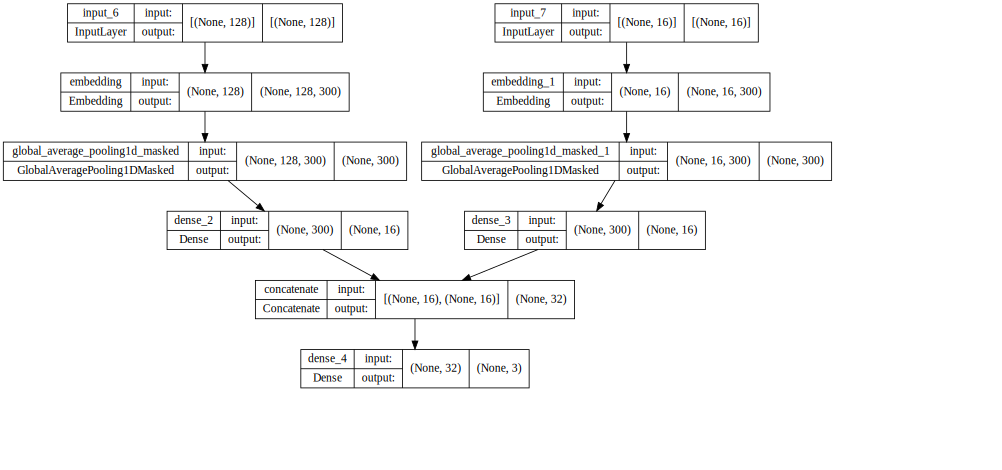

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model31, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  

Train and evaluate your model:

In [ ]:
# your code goes here
history31 = model31.fit([x_train_review_pad_glove, x_train_aspect_pad_glove],
                    y_train,
                    epochs=200,
                    batch_size=512,
                    validation_data=([x_dev_review_pad_glove, x_dev_aspect_pad_glove], y_dev),
                    verbose=1)

results31 = model31.evaluate([x_test_review_pad_glove, x_test_aspect_pad_glove], y_test)

print("Loss: {} and Accuracy: {}".format(results31[0], results31[1]))




Epoch 1/200
22/22 [==============================] - 2s 32ms/step - loss: 0.6571 - accuracy: 0.4455 - val_loss: 0.6278 - val_accuracy: 0.4535
Epoch 2/200
22/22 [==============================] - 1s 25ms/step - loss: 0.6169 - accuracy: 0.4507 - val_loss: 0.6059 - val_accuracy: 0.4535
Epoch 3/200
22/22 [==============================] - 1s 25ms/step - loss: 0.6026 - accuracy: 0.4508 - val_loss: 0.5943 - val_accuracy: 0.4542
Epoch 4/200
22/22 [==============================] - 1s 24ms/step - loss: 0.5916 - accuracy: 0.4575 - val_loss: 0.5820 - val_accuracy: 0.4752
Epoch 5/200
22/22 [==============================] - 1s 24ms/step - loss: 0.5801 - accuracy: 0.4914 - val_loss: 0.5694 - val_accuracy: 0.5203
Epoch 6/200
22/22 [==============================] - 1s 24ms/step - loss: 0.5684 - accuracy: 0.5326 - val_loss: 0.5574 - val_accuracy: 0.5511
Epoch 7/200
22/22 [==============================] - 1s 24ms/step - loss: 0.5574 - accuracy: 0.5448 - val_loss: 0.5463 - val_accuracy: 0.5653
Epoch 

## Model 3-2 CNN or LSTM model with multiple-input

Modify the previous CNN or LSTM model to be compatible with multiple-input, similar to model 3-1. 

In [27]:
# your code goes here
# Tips: The activation function of the output layer is softmax.
from keras.layers import Input, Embedding, Dense, concatenate, LSTM
from keras.models import Model
from keras.layers.core import Dense, Reshape

# define two sets of inputs
inputA = Input(shape=(128,), dtype='int32')
inputB = Input(shape=(16,), dtype='int32')


# the first branch operates on the first input
glove_embeddingA = createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)(inputA)
lstmA = LSTM(128)(glove_embeddingA)
hidden1 = Dense(16)(lstmA)

x = Model(inputs=inputA, outputs=hidden1)

# the second branch opreates on the second input
glove_embeddingB = createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)(inputB)
lstmB = LSTM(16)(glove_embeddingB)
hidden2 = Dense(16)(lstmB)

y = Model(inputs=inputB, outputs=hidden2)

# combine the output of the two branches
combined = concatenate([x.output, y.output])


z = Dense(3, activation='softmax')(combined)

model3b = Model(inputs=[x.input, y.input], outputs=z)
model3b.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
model3b.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 128, 300)     120000300   ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 16, 300)      120000300   ['input_2[0][0]']                
                                                                                            

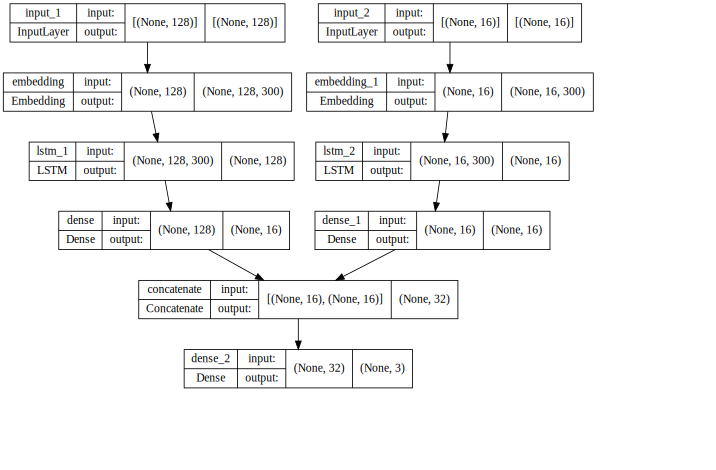

In [28]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model3b, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  

In [29]:
history3b = model3b.fit([x_train_review_pad_glove, x_train_aspect_pad_glove],
                    y_train,
                    epochs=200,
                    batch_size=512,
                    validation_data=([x_dev_review_pad_glove, x_dev_aspect_pad_glove], y_dev),
                    verbose=1)

results3b = model3b.evaluate([x_test_review_pad_glove, x_test_aspect_pad_glove], y_test)

print("Loss: {} and Accuracy: {}".format(results3b[0], results3b[1]))

Epoch 1/200
22/22 [==============================] - 11s 144ms/step - loss: 0.6449 - accuracy: 0.4408 - val_loss: 0.6168 - val_accuracy: 0.4535
Epoch 2/200
22/22 [==============================] - 2s 84ms/step - loss: 0.6020 - accuracy: 0.4588 - val_loss: 0.5676 - val_accuracy: 0.5383
Epoch 3/200
22/22 [==============================] - 2s 84ms/step - loss: 0.5542 - accuracy: 0.5438 - val_loss: 0.5352 - val_accuracy: 0.5593
Epoch 4/200
22/22 [==============================] - 2s 85ms/step - loss: 0.5344 - accuracy: 0.5703 - val_loss: 0.5241 - val_accuracy: 0.5878
Epoch 5/200
22/22 [==============================] - 2s 85ms/step - loss: 0.5257 - accuracy: 0.5862 - val_loss: 0.5169 - val_accuracy: 0.5953
Epoch 6/200
22/22 [==============================] - 2s 85ms/step - loss: 0.5214 - accuracy: 0.5924 - val_loss: 0.5118 - val_accuracy: 0.6014
Epoch 7/200
22/22 [==============================] - 2s 85ms/step - loss: 0.5168 - accuracy: 0.5932 - val_loss: 0.5068 - val_accuracy: 0.6089
Epoc

#  Model 4: Another LSTM model

If you study the data carefully, you can find that every aspect appears in the review sentence, which means we can extract the aspect information from the sentence. In most cases, the polarity of the aspect is determined by the content near it. Therefore, an LSTM can transfer the information of adjacent context to the aspect. We only need to extract the aspect vector to calculate its polarity, without analyzing the whole sentence.

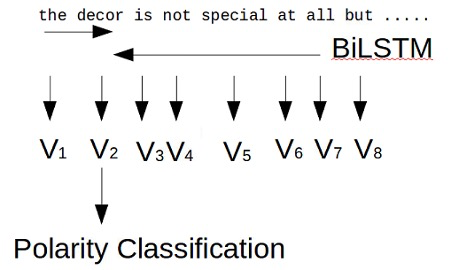

(This is a bit like a simplified version of the "unknown target" sequence tagging models discussed in lectures - but we're only trying to tag the one part of the sequence that we know corresponds to the aspect mention.)

In [30]:
def aspect_mask(reviews, aspects, dataset):
  mask = []
  for review,aspect,data in zip(reviews, aspects, dataset):
    find_aspect = False
    for j in range(5):
      aspect_num = len(aspect)
      aspect_str = " ".join(aspect)
      aspect_len = int(len(aspect_str) - 1) * (j+1)
      offset = 0
      for i,r in enumerate(review):
        if i + aspect_num <= len(review):
          r_context = " ".join(review[i:i+aspect_num])
          if r_context == aspect_str and offset + aspect_len >  int(data[3]) and offset + aspect_len <  int(data[4]):
            find_aspect = True
            sentence_mask = [0] * len(review)
            sentence_mask[i:i+aspect_num] = [1] * aspect_num
            mask.append(sentence_mask)
            break
          else:
            offset += (len(r) + 1)
      if find_aspect:
        break

    if not find_aspect:
      for j in range(5):
        aspect_len = int(len(aspect_str) - 1) * (j+1)
        offset = 0
        for i,r in enumerate(review):
          if i + aspect_num <= len(review):
            r_context = " ".join(review[i:i+aspect_num])
            if r_context.startswith(aspect_str) and offset + aspect_len >  int(data[3]) and offset + aspect_len <  int(data[4]):
              find_aspect = True
              sentence_mask = [0] * len(review)
              sentence_mask[i:i+aspect_num] = [1] * aspect_num
              mask.append(sentence_mask)
              break
            else:
              offset += (len(r) + 1)
        if find_aspect:
          break

    if not find_aspect:
      for j in range(5):
        aspect_len = int(len(aspect_str) - 1) * (j+1)
        offset = 0
        for i,r in enumerate(review):
          if i + aspect_num <= len(review):
            r_context = " ".join(review[i:i+aspect_num])
            if r_context.endswith(aspect_str) and offset + aspect_len >  int(data[3]) and offset + aspect_len <  int(data[4]):
              find_aspect = True
              sentence_mask = [0] * len(review)
              sentence_mask[i:i+aspect_num] = [1] * aspect_num
              mask.append(sentence_mask)
              break
            else:
              offset += (len(r) + 1)
        if find_aspect:
          break

    if not find_aspect:
      print("annotation error:")
      print(data)
      sentence_mask = [0] * len(review)
      sentence_mask[16] = 1
      mask.append(sentence_mask)

    # if aspect_num > 1:
    #   print(mask[-1])

  return mask
x_train_aspect_mask = aspect_mask(x_train_review, x_train_aspect, train)
x_dev_aspect_mask = aspect_mask(x_dev_review, x_dev_aspect, val)
x_test_aspect_mask = aspect_mask(x_test_review, x_test_aspect, test)

print()
print()
print()
assert len(x_train_aspect_mask) == len(train)
assert len(x_test_aspect_mask) == len(x_test_aspect)

print(train[0])
print(x_train_aspect_mask[0])
print(train[1])
print(x_train_aspect_mask[1])
print(train[2])
print(x_train_aspect_mask[2])
print(train[3])
print(x_train_aspect_mask[3])
print(train[10319])
print(x_train_aspect_mask[10319])

annotation error:
['i love the food here, and although it is pricey, the entree comes with rice, naan, dal, and salad, which makes it worthwhile.', 'd al', 'neutral', '24', '28']



['the decor is not special at all but their food and amazing prices make up for it.', 'decor', 'negative', '4', '9']
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['the decor is not special at all but their food and amazing prices make up for it.', 'food', 'positive', '42', '46']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
['the decor is not special at all but their food and amazing prices make up for it.', 'prices', 'positive', '59', '65']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
['when tables opened up, the manager sat another party before us.', 'tables', 'neutral', '5', '11']
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['the scene there are two distinct personalities to the place: the loud, seemingly always-crowded bar with hanging paper decorations and dim lighting, and the two main dinin

In [31]:
x_train_aspect_mask_pad = keras.preprocessing.sequence.pad_sequences(x_train_aspect_mask,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=128)
x_dev_aspect_mask_pad = keras.preprocessing.sequence.pad_sequences(x_dev_aspect_mask,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=128)
x_test_aspect_mask_pad = keras.preprocessing.sequence.pad_sequences(x_test_aspect_mask,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=128)
x_train_aspect_mask_pad[0]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [32]:
import tensorflow as tf

from keras.layers import Input, Embedding, Dense, concatenate, LSTM, Bidirectional, Dot
from keras.models import Model
from keras.layers.core import Dense, Reshape


maxlen = 200
inputlayer1 = Input(shape=(128,), dtype='int32')

glove_embedding = createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)(inputlayer1)

bilstm = Bidirectional(LSTM(100, return_sequences=True), name='BiLSTM', )(glove_embedding)

inputlayer2 = Input(shape=(128,), dtype='float32')

dot = Dot(axes=1)([bilstm, inputlayer2])

hidden1 = Dense(16)(dot)

output = Dense(3, activation='softmax')(hidden1)

model_4 = Model(inputs=[inputlayer1, inputlayer2], outputs=output)

model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

model_4.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 128, 300)     120000300   ['input_3[0][0]']                
                                                                                                  
 BiLSTM (Bidirectional)         (None, 128, 200)     320800      ['embedding_2[0][0]']            
                                                                                                  
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                            

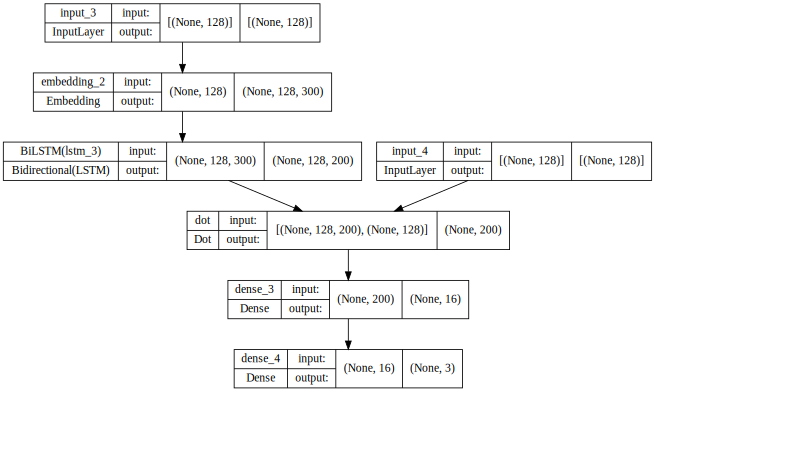

In [33]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model_4, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  

In [34]:
history4 = model_4.fit([x_train_review_pad_glove, x_train_aspect_mask_pad], y_train,
                    epochs=200,
                    batch_size=512,
                    validation_data=([x_dev_review_pad_glove, x_dev_aspect_mask_pad], y_dev),
                    verbose=1)

results4 = model_4.evaluate([x_test_review_pad_glove, x_test_aspect_mask_pad], y_test)

print("Loss: {} and Accuracy: {}".format(results4[0], results4[1]))

Epoch 1/200
22/22 [==============================] - 8s 194ms/step - loss: 0.5751 - accuracy: 0.5449 - val_loss: 0.5099 - val_accuracy: 0.6389
Epoch 2/200
22/22 [==============================] - 3s 151ms/step - loss: 0.4863 - accuracy: 0.6572 - val_loss: 0.4710 - val_accuracy: 0.6794
Epoch 3/200
22/22 [==============================] - 3s 151ms/step - loss: 0.4430 - accuracy: 0.6977 - val_loss: 0.4439 - val_accuracy: 0.7020
Epoch 4/200
22/22 [==============================] - 3s 150ms/step - loss: 0.4151 - accuracy: 0.7177 - val_loss: 0.4335 - val_accuracy: 0.7185
Epoch 5/200
22/22 [==============================] - 3s 151ms/step - loss: 0.3848 - accuracy: 0.7448 - val_loss: 0.4135 - val_accuracy: 0.7260
Epoch 6/200
22/22 [==============================] - 3s 152ms/step - loss: 0.3583 - accuracy: 0.7697 - val_loss: 0.4112 - val_accuracy: 0.7327
Epoch 7/200
22/22 [==============================] - 3s 151ms/step - loss: 0.3302 - accuracy: 0.7896 - val_loss: 0.4162 - val_accuracy: 0.7260